## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Extracting data from csv files

In [2]:
DATA_PATH = os.getcwd()+ '/data/'
IMAGES_PATH = os.getcwd()+ '/images/'
MIN_REWARD = -1.0

def read_data(path):
    df = pd.read_csv(path)
    data = df.to_numpy().reshape((len(df),))
    return data

def get_data(training_names, total_episodes, steps_per_episode, average_episode_count):

    if len(training_names) == 1:
        
        training_name = training_names[0]
        
        rewards = read_data(DATA_PATH + training_names[0] + '_rewards.csv')
        steps = read_data(DATA_PATH + training_names[0] + '_steps.csv')
        episodic_rewards = read_data(DATA_PATH + training_names[0] + '_episodic_rewards.csv')
        average_episodic_rewards = read_data(DATA_PATH + training_names[0] + '_average_episodic_rewards.csv')
        
    elif len(training_names) > 1:
        
        rewards = rewards = read_data(DATA_PATH + training_names[0] + '_rewards.csv')
        steps = read_data(DATA_PATH + training_names[0] + '_steps.csv')
        episodic_rewards = read_data(DATA_PATH + training_names[0] + '_episodic_rewards.csv')
        average_episodic_rewards = read_data(DATA_PATH + training_names[0] + '_average_episodic_rewards.csv')
        
        for i in range(1,len(training_names)):
            rewards = np.concatenate((rewards, read_data(DATA_PATH + training_names[i] + '_rewards.csv'))) 
            steps = np.concatenate((steps, read_data(DATA_PATH + training_names[i] + '_steps.csv')))
            episodic_rewards = np.concatenate((episodic_rewards, read_data(DATA_PATH + training_names[i] + '_episodic_rewards.csv')))
            average_episodic_rewards = np.concatenate((average_episodic_rewards, read_data(DATA_PATH + training_names[i] + '_average_episodic_rewards.csv')))

    return rewards, steps, episodic_rewards, average_episodic_rewards, total_episodes, steps_per_episode, average_episode_count

## Plotting results

In [3]:
from scipy import optimize

def linear_regression(x, a, b):
    return a*x+b

def plot_results(training_name, rewards, steps, episodic_rewards, average_episodic_rewards, total_episodes, steps_per_episode, average_episode_count, left_index=-51, right_index=-1):
    
    params = [0, 0]
    params, _ = optimize.curve_fit(linear_regression, np.arange(1,average_episodic_rewards.shape[0]+1), np.log(1+abs(min(average_episodic_rewards))+average_episodic_rewards), params)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (20,10), dpi = 120)
    ax = axes.ravel()

    ax[0].plot(np.arange(1,episodic_rewards.shape[0]+1), episodic_rewards, color='tomato', linewidth=1.0, label='episodic')
    ax[0].plot(np.arange(1,average_episodic_rewards.shape[0]+1), average_episodic_rewards, color='darkgreen', linewidth=1.5, label='average episodic')
    ax[0].grid()
    ax[0].set_xlabel('Episode', fontsize=16)
    ax[0].set_ylabel('Rt', fontsize=16)
    ax[0].set_title('Episodic and Average Episodic Reward \n(average over every last {} episodes)'.format(average_episode_count), fontsize=16)
    ax[0].legend(loc='upper left')

    ax[1].plot(np.arange(1,episodic_rewards.shape[0]+1), np.log(1+abs(min(episodic_rewards))+episodic_rewards), color='tomato', linewidth=1.0, label='episodic')
    ax[1].plot(np.arange(1,average_episodic_rewards.shape[0]+1), np.log(1+abs(min(average_episodic_rewards))+average_episodic_rewards), color='darkgreen', linewidth=1.5, label='average episodic')
    ax[1].plot(np.arange(1,average_episodic_rewards.shape[0]+1), linear_regression(np.arange(1,average_episodic_rewards.shape[0]+1), *params), color='blue', linewidth=1.2, label='fitted line')
    ax[1].grid()
    ax[1].set_xlabel('Episode', fontsize=16)
    ax[1].set_ylabel('Rt', fontsize=16)
    ax[1].set_title('Episodic and Average Episodic Reward (in log y scale)\n(average over every last {} episodes)'.format(average_episode_count), fontsize=16)
    ax[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    fig.savefig(IMAGES_PATH + training_name + '_episodic_and_average_rewards', facecolor = 'white', bbox_inches='tight')

    left_index_for_title = left_index+1 if left_index >= 0 else total_episodes+left_index+1
    right_index_for_title = right_index+1 if right_index >= 0 else total_episodes+right_index+1

    last_episodes_rewards = rewards[steps[left_index]:steps[right_index]]

    fig = plt.figure(figsize=(20,10), dpi=120)
    plt.plot(np.arange(steps[left_index],steps[right_index]), last_episodes_rewards, color='darkgreen', label='iteration reward')

    for step in steps[left_index:right_index]:
        if step == steps[right_index-1]:
            plt.axvline(step,color='tomato', linestyle='--', label='end of episode')
        else:
            plt.axvline(step,color='tomato', linestyle='--')

    plt.axhline(MIN_REWARD, color='blue', linestyle='-.', label='min reward')
    plt.title('Iteration rewards from {:d}. to {:d}. episode'.format(left_index_for_title, right_index_for_title), fontsize=16)
    plt.xlabel('#No. Iteration', fontsize=16)
    plt.ylabel('Rt', fontsize=16)
    plt.legend(loc='upper right')
    plt.grid()

    plt.tight_layout()
    plt.show()

    fig.savefig(IMAGES_PATH + training_name + '_iteration_rewards', facecolor = 'white', bbox_inches='tight')

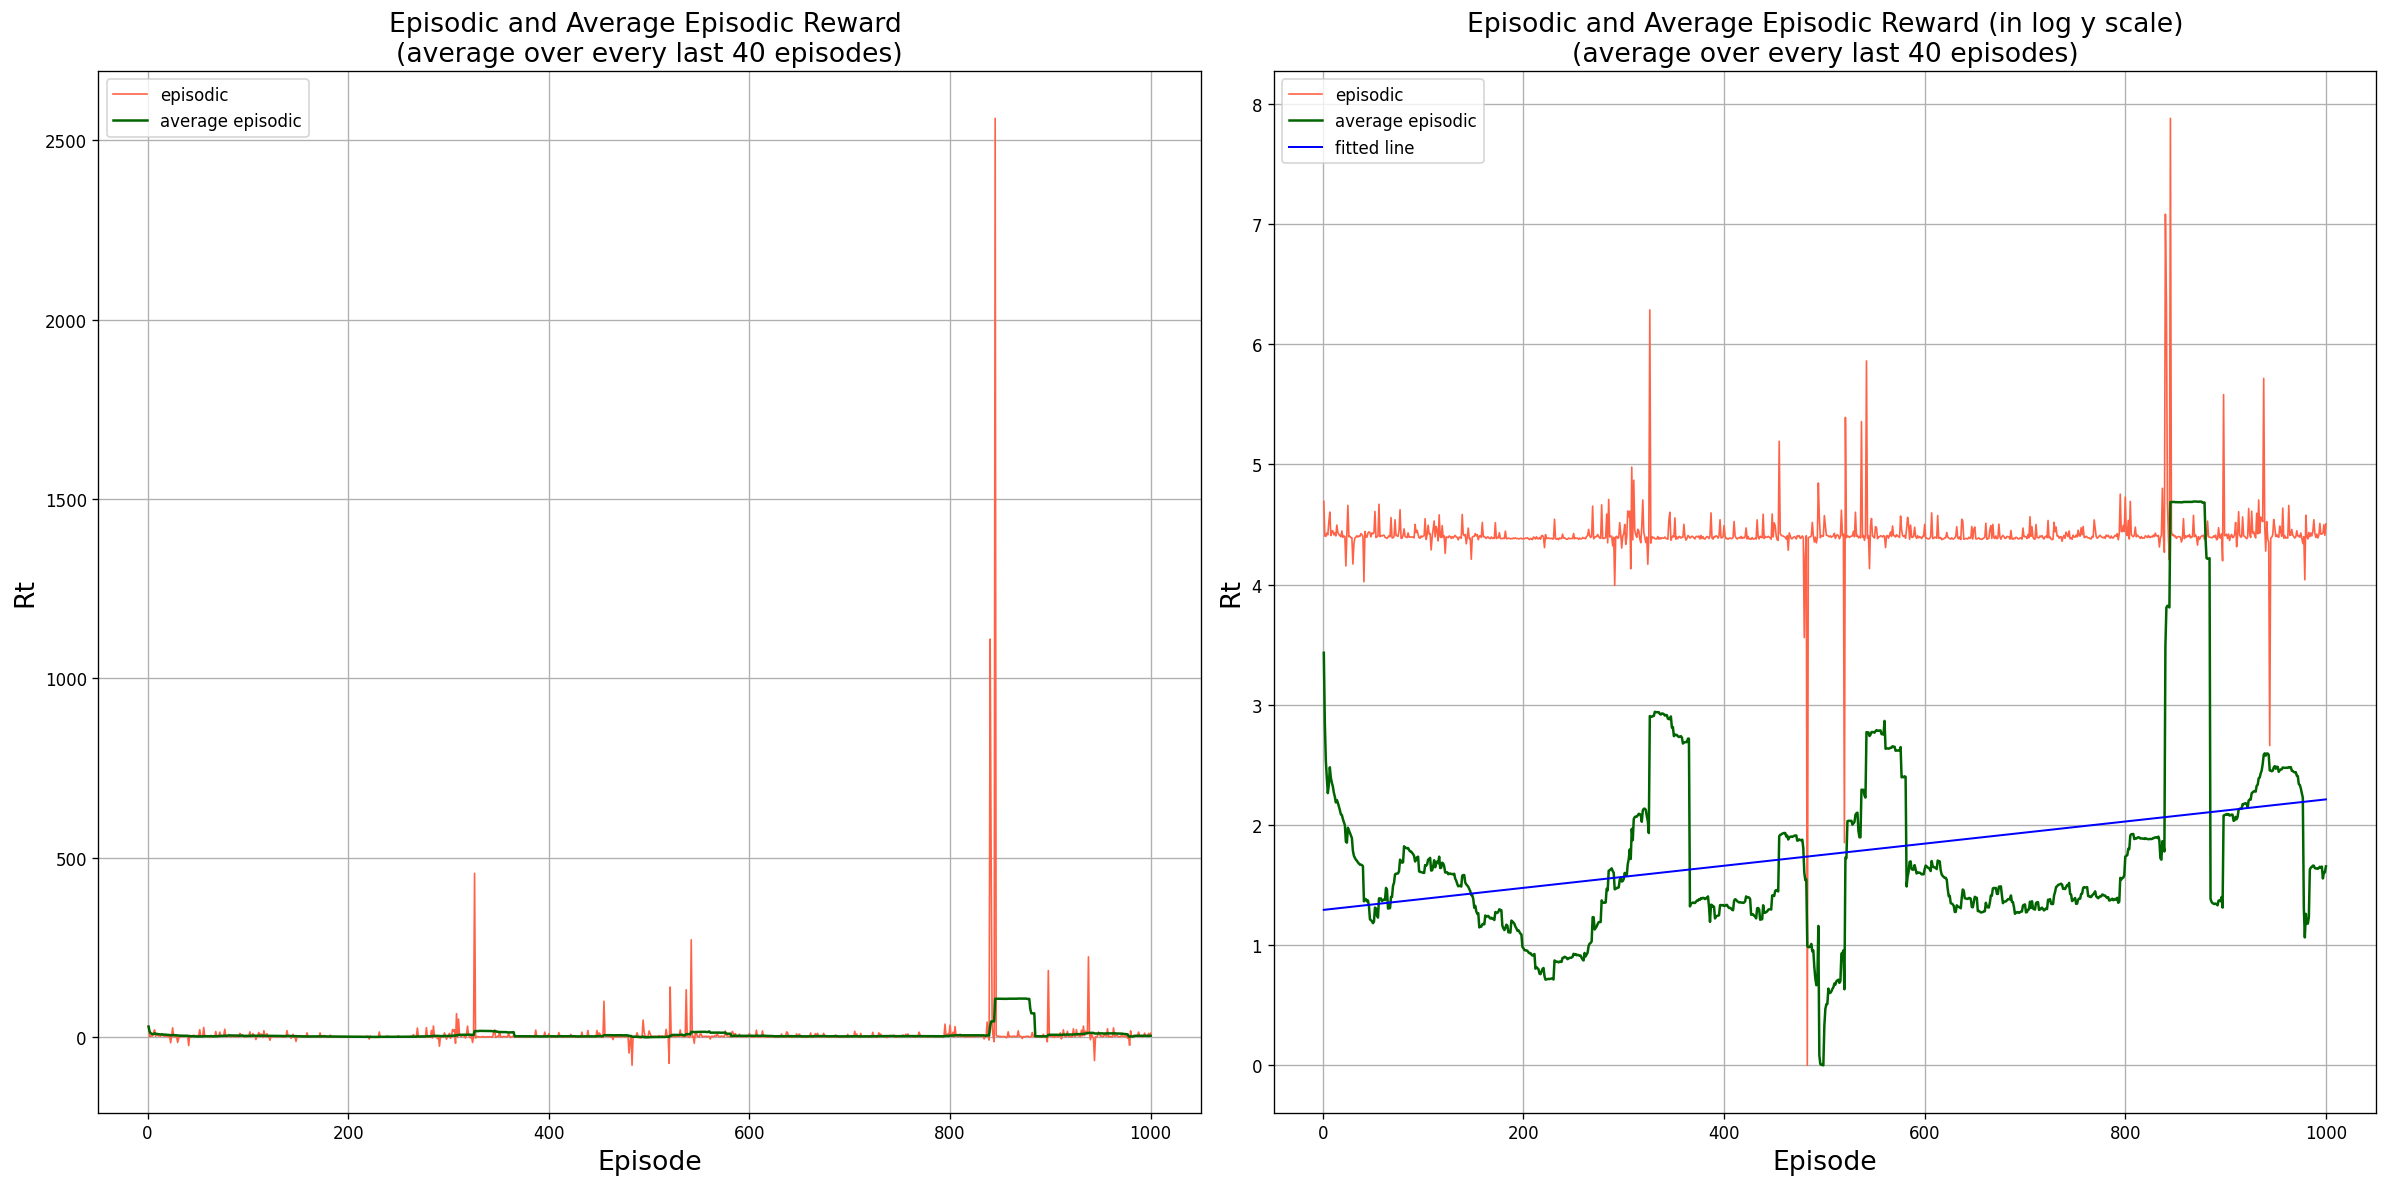

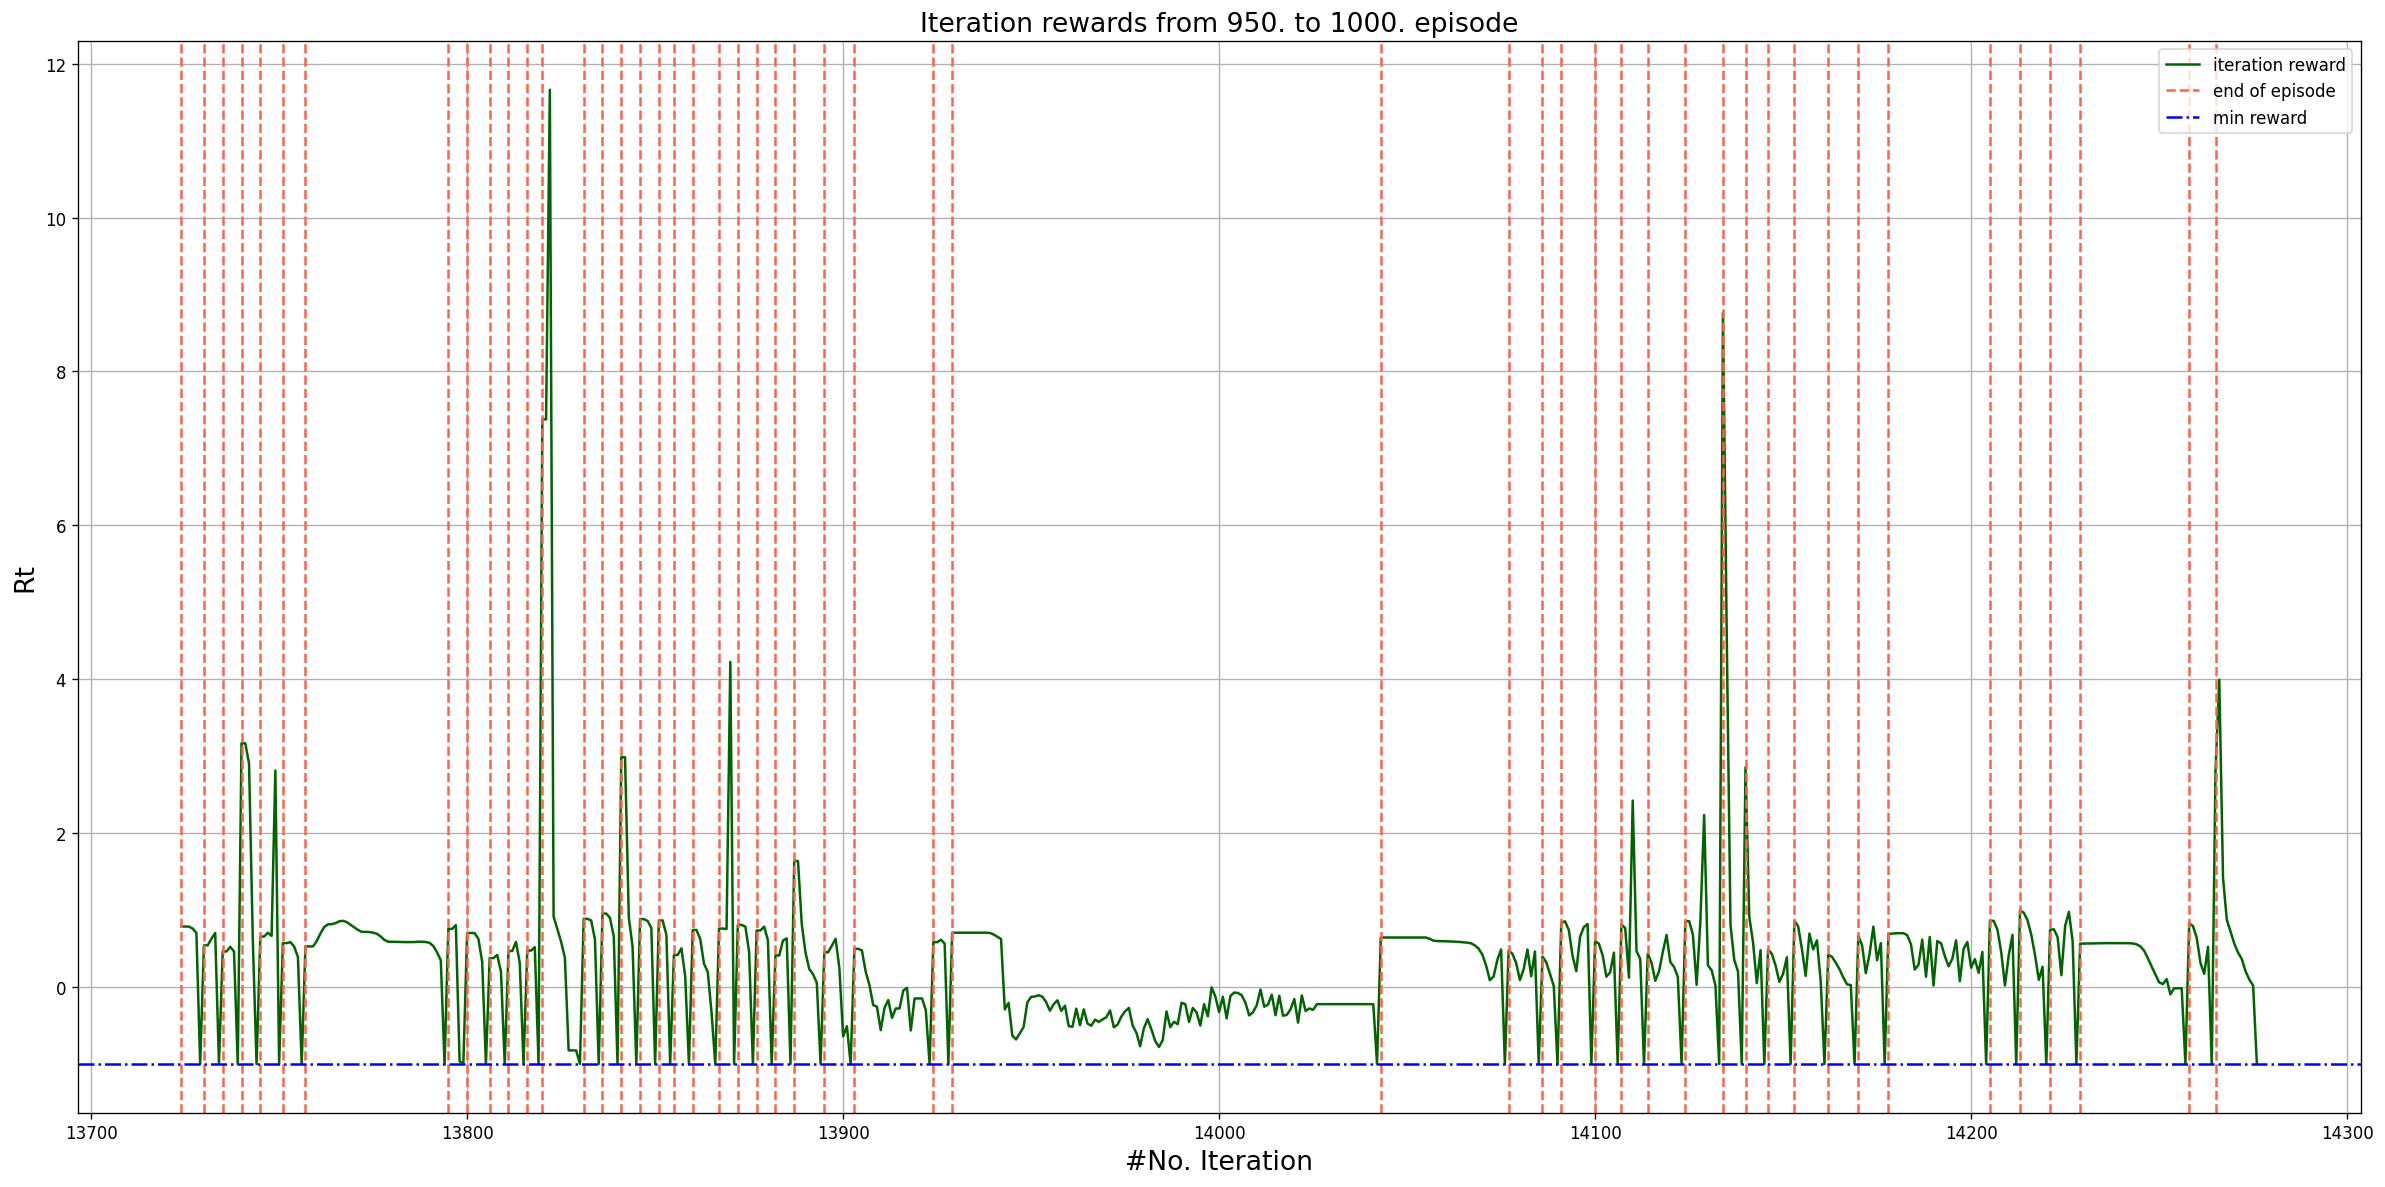

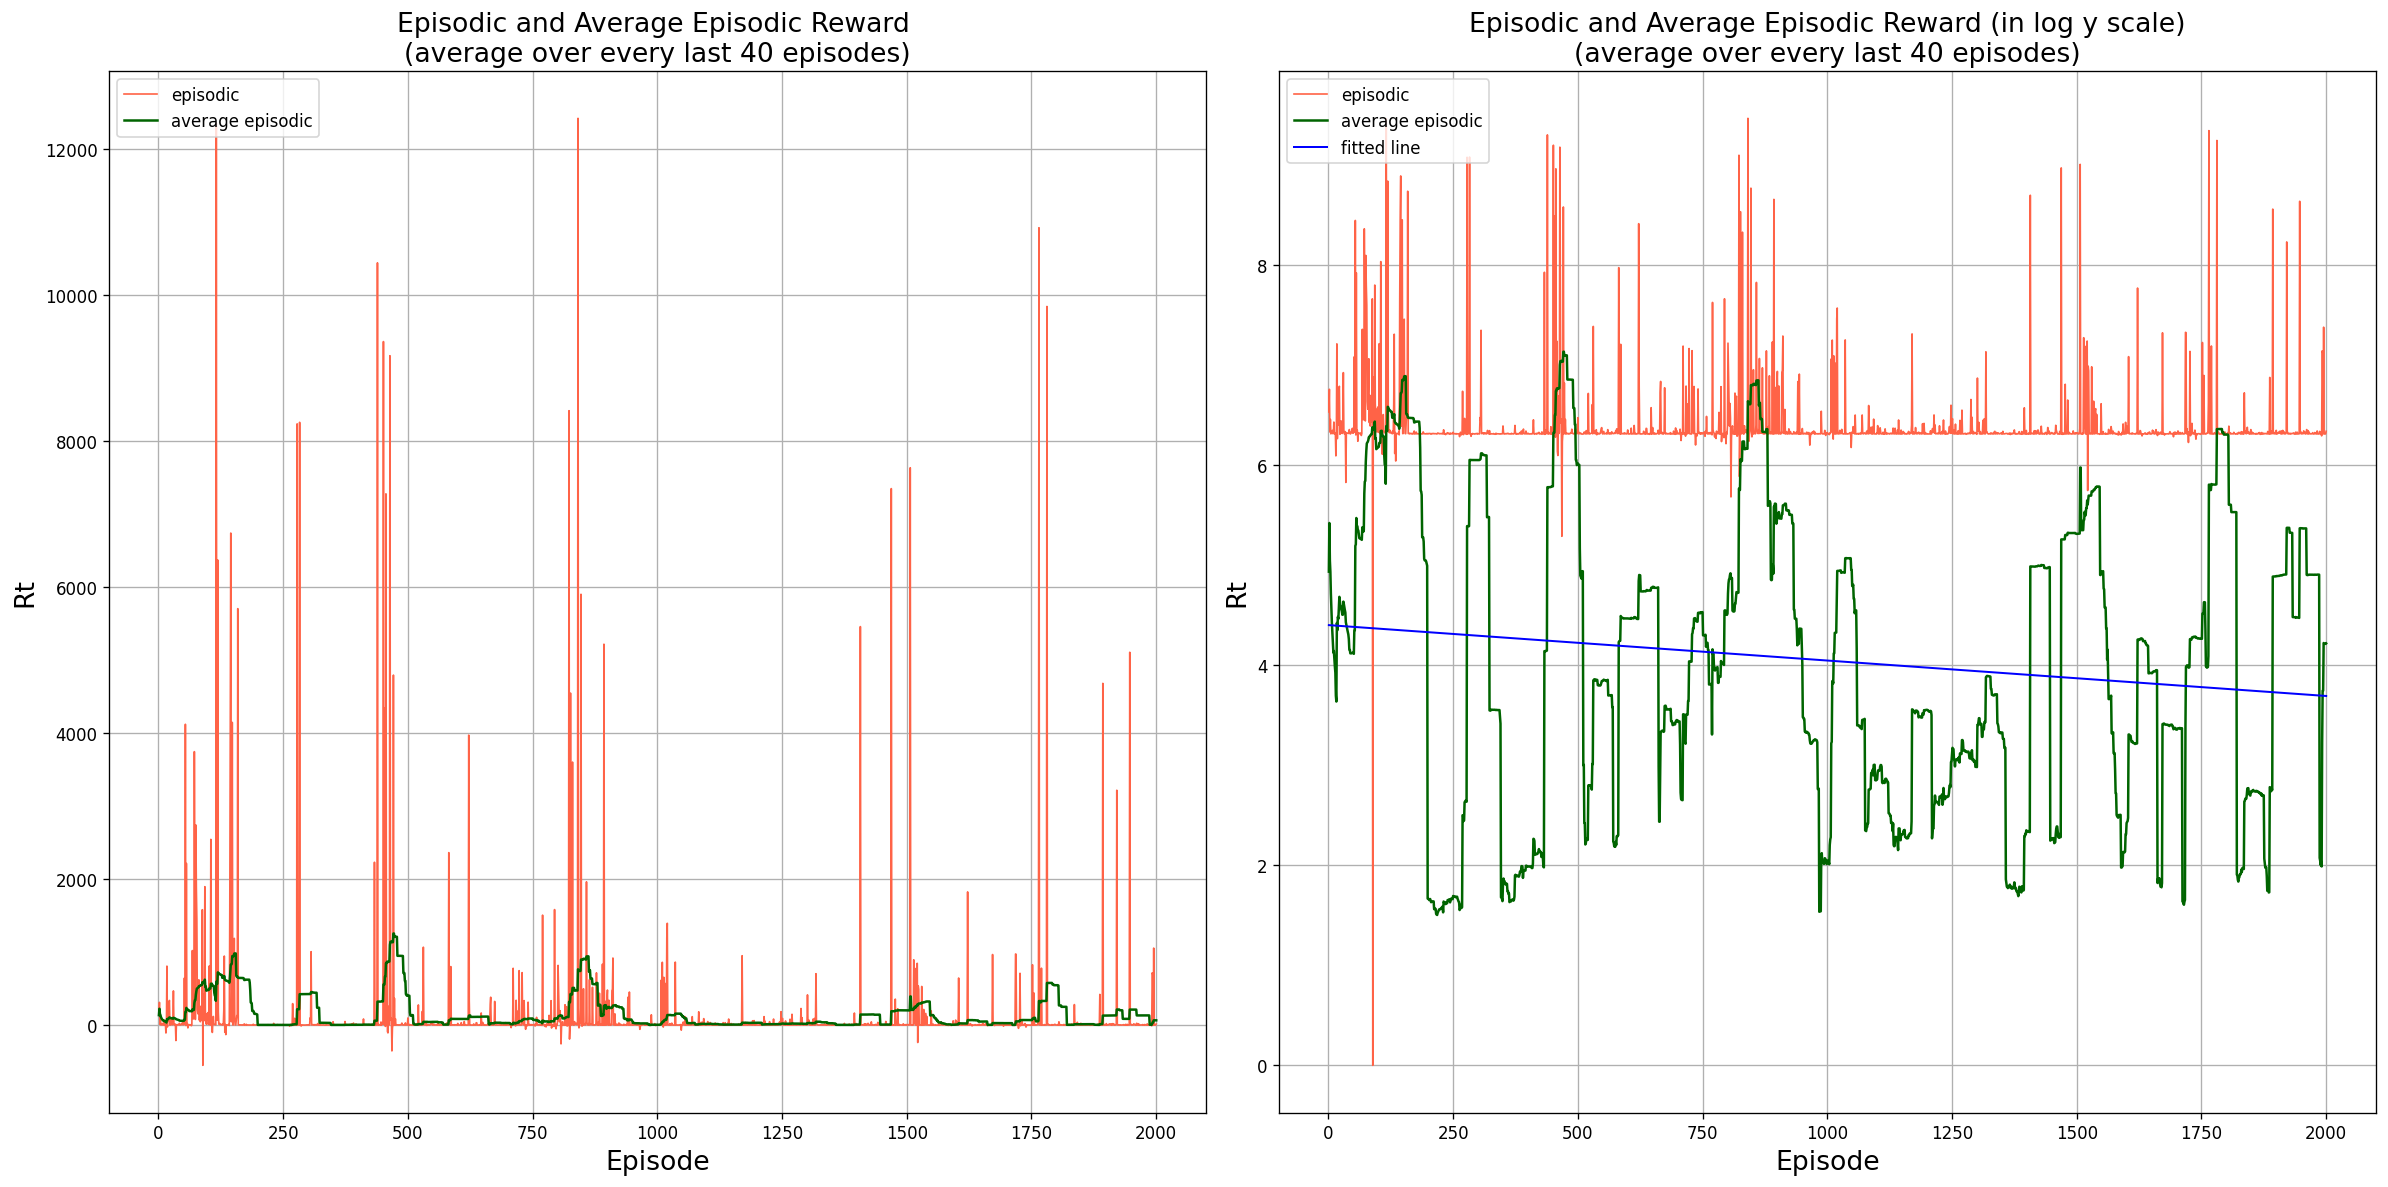

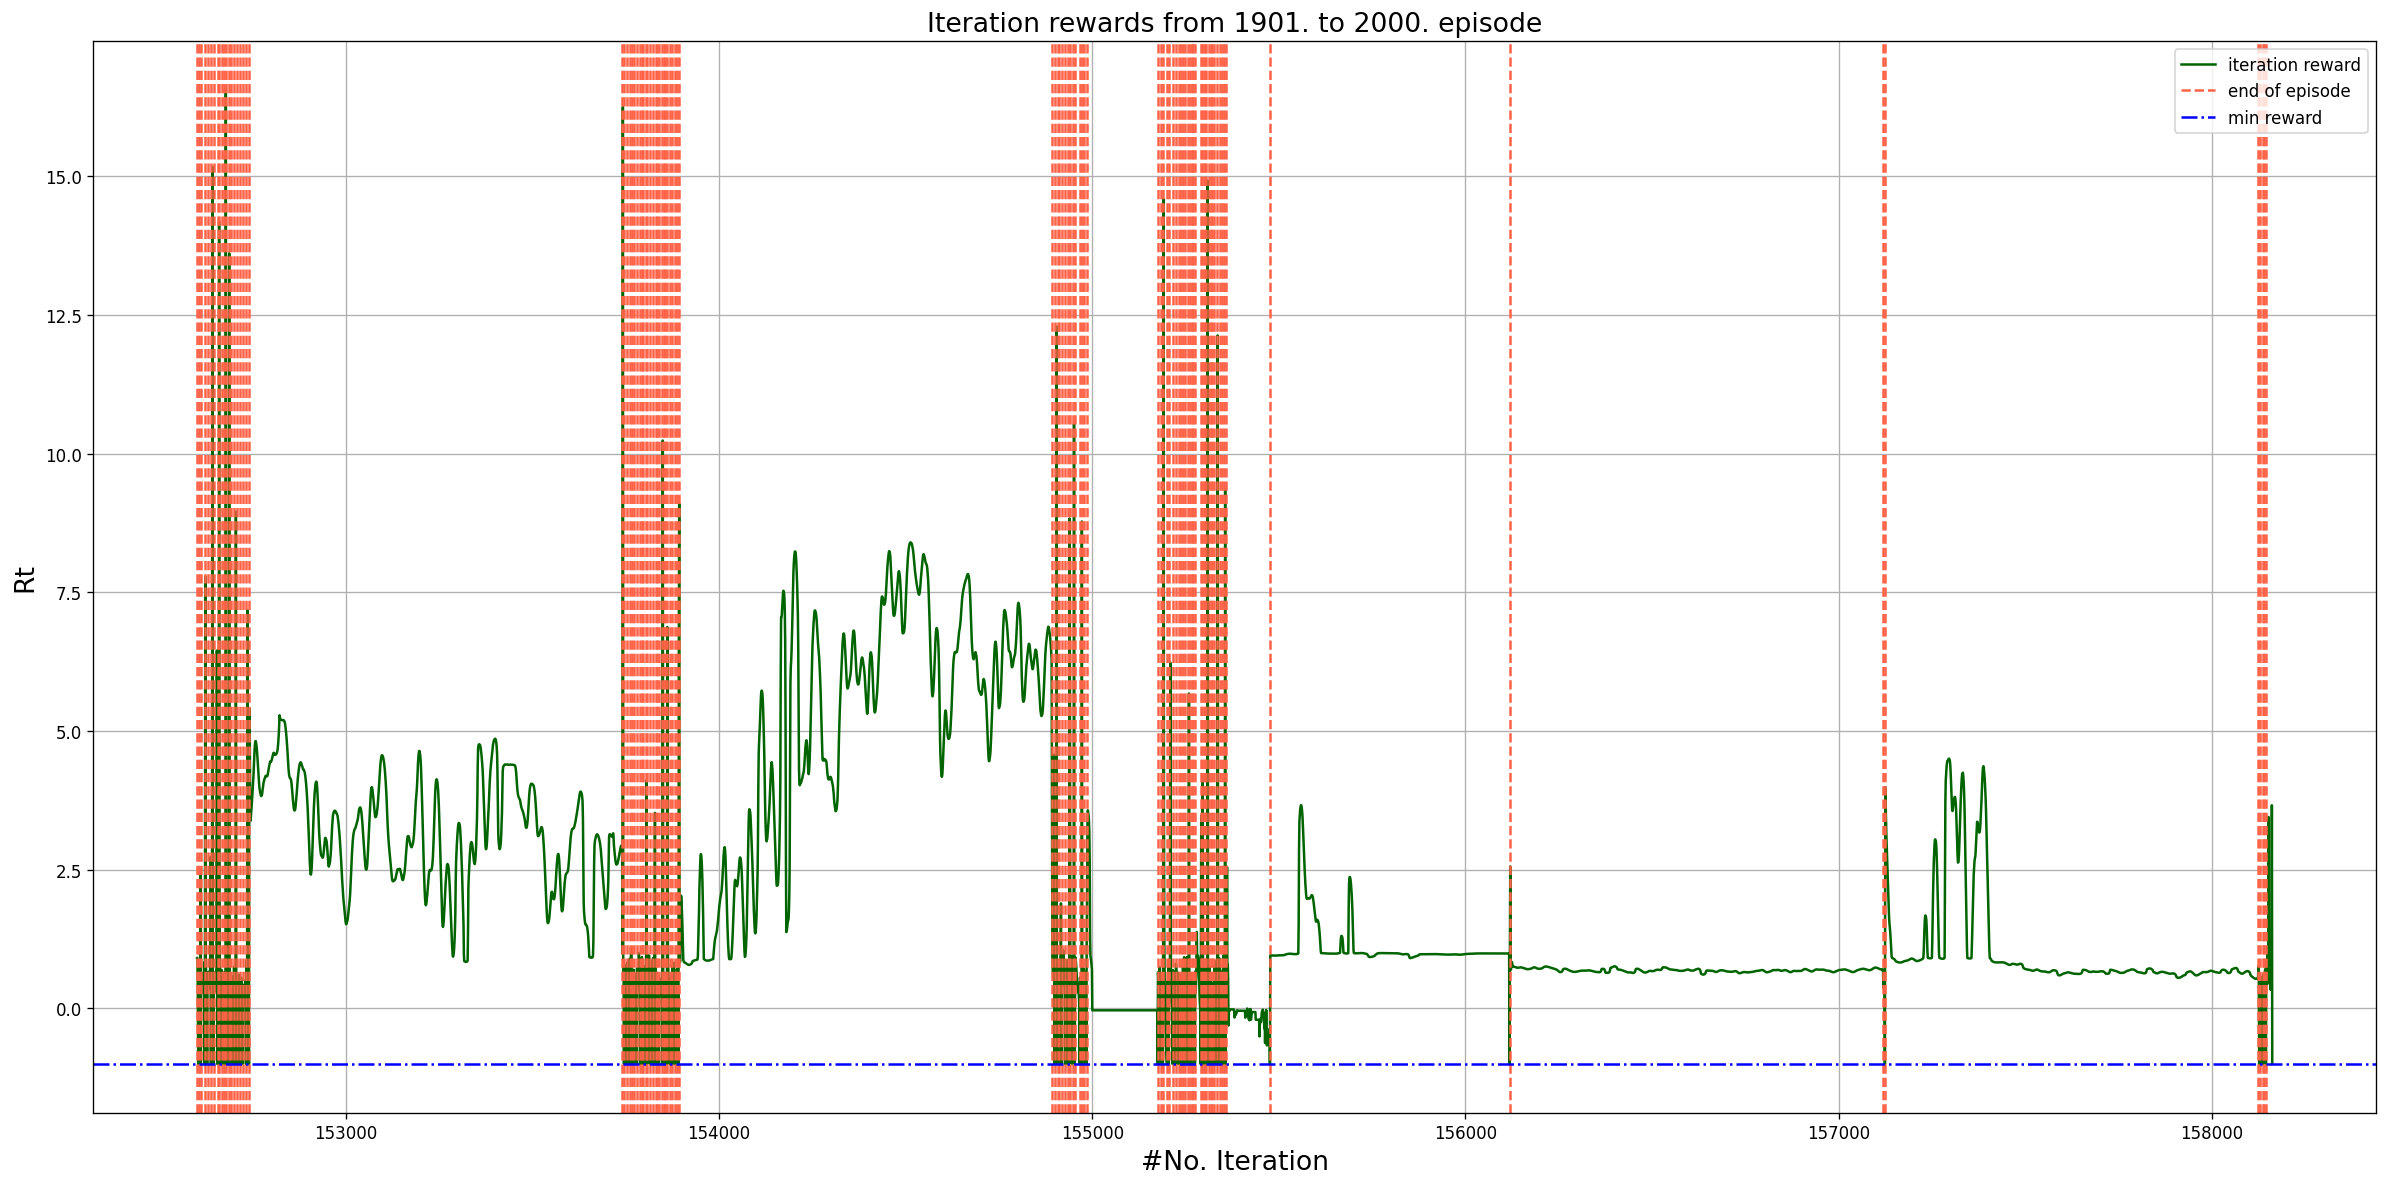

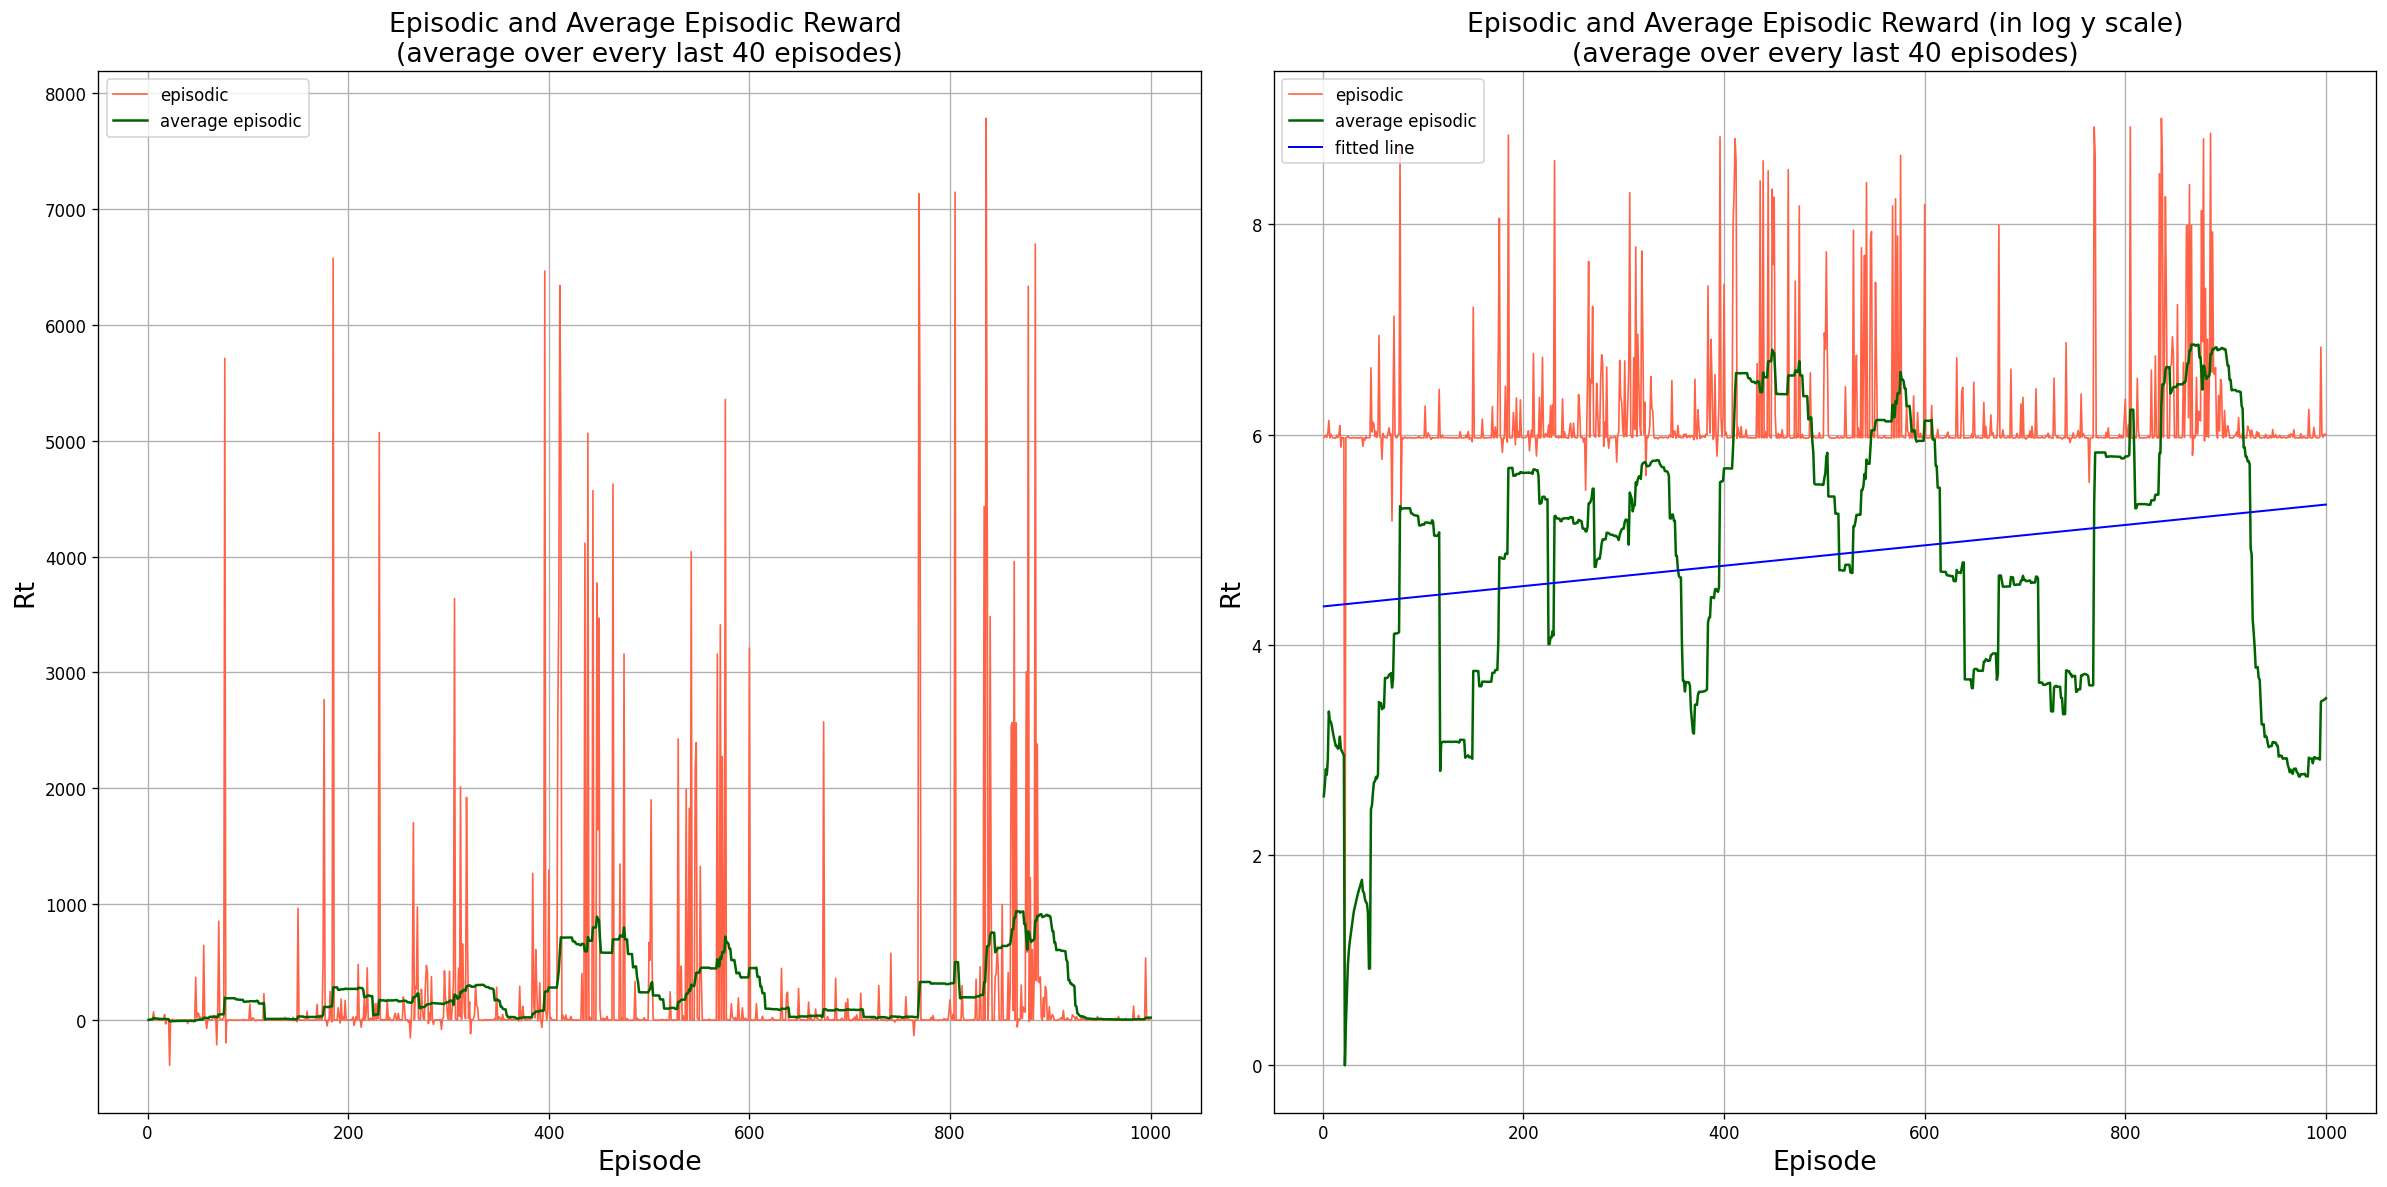

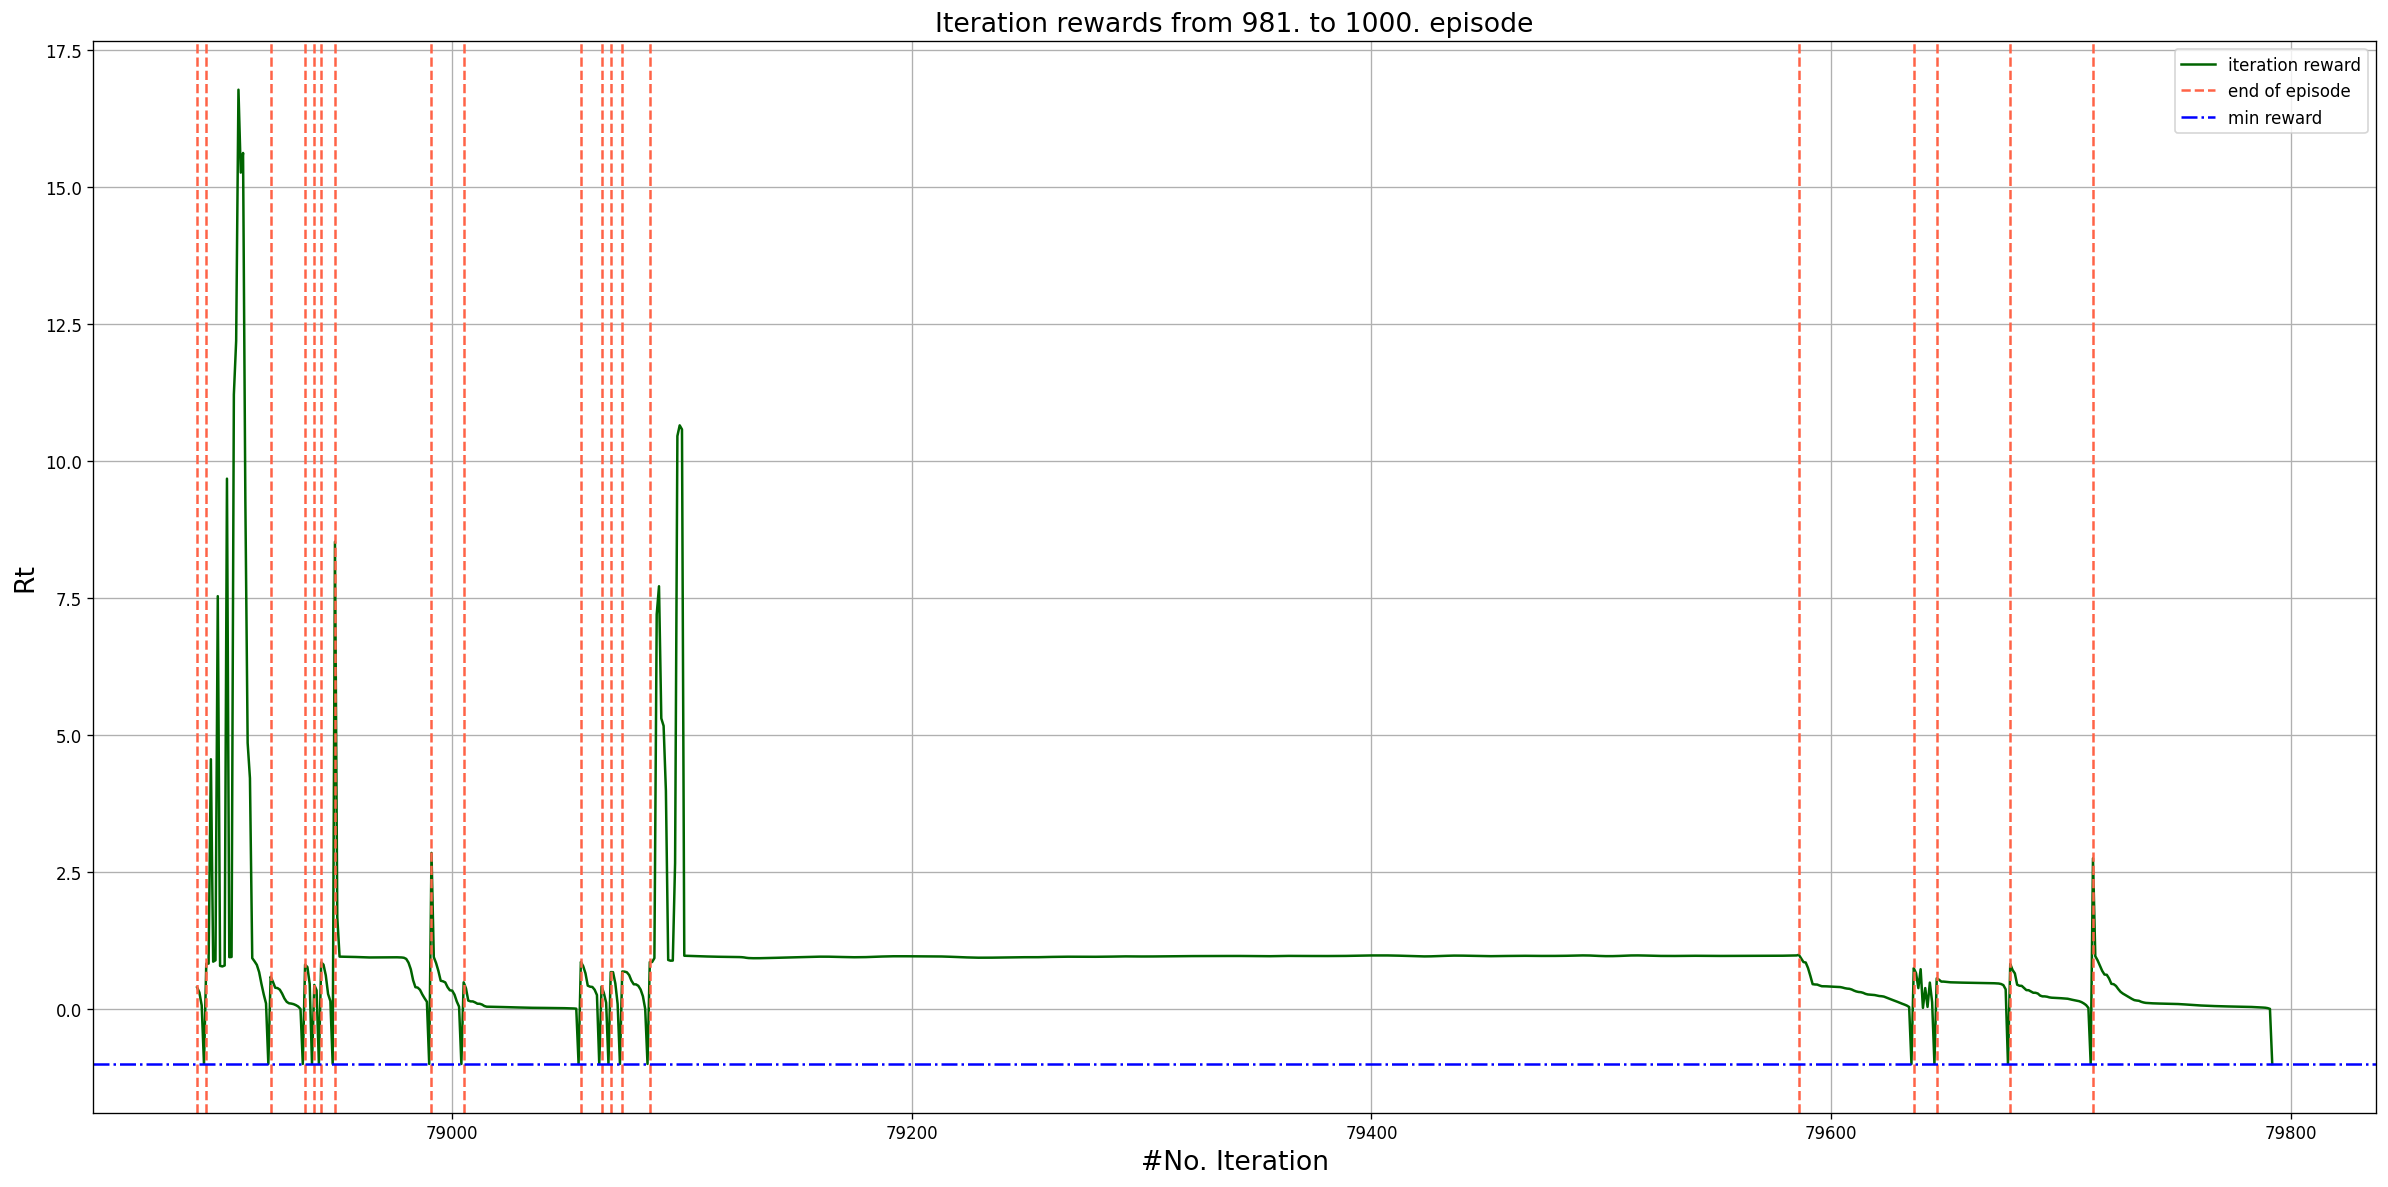

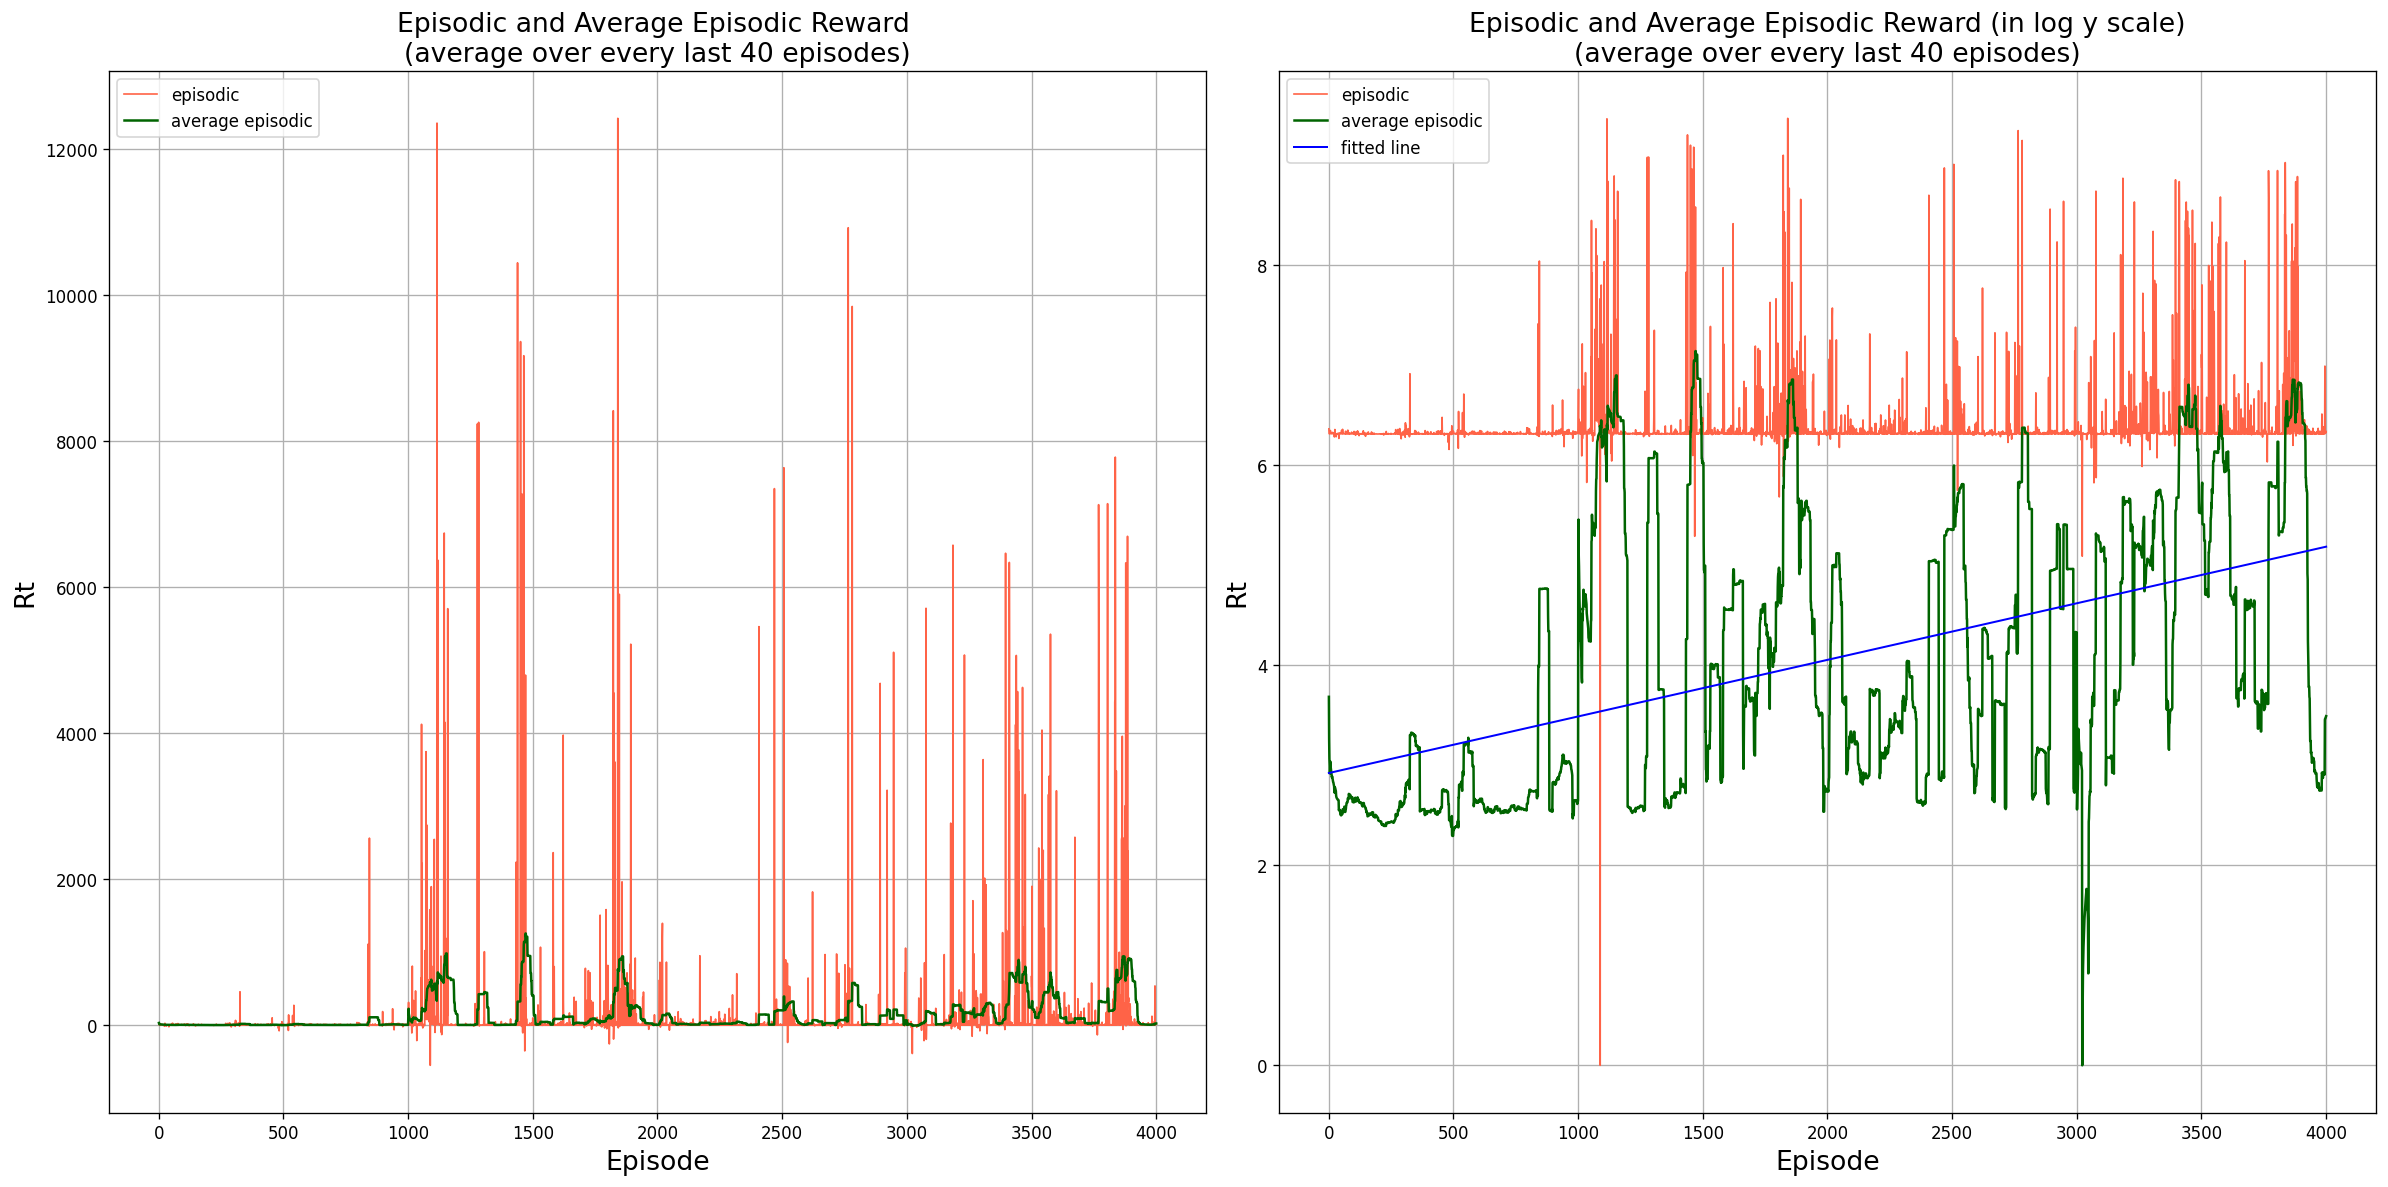

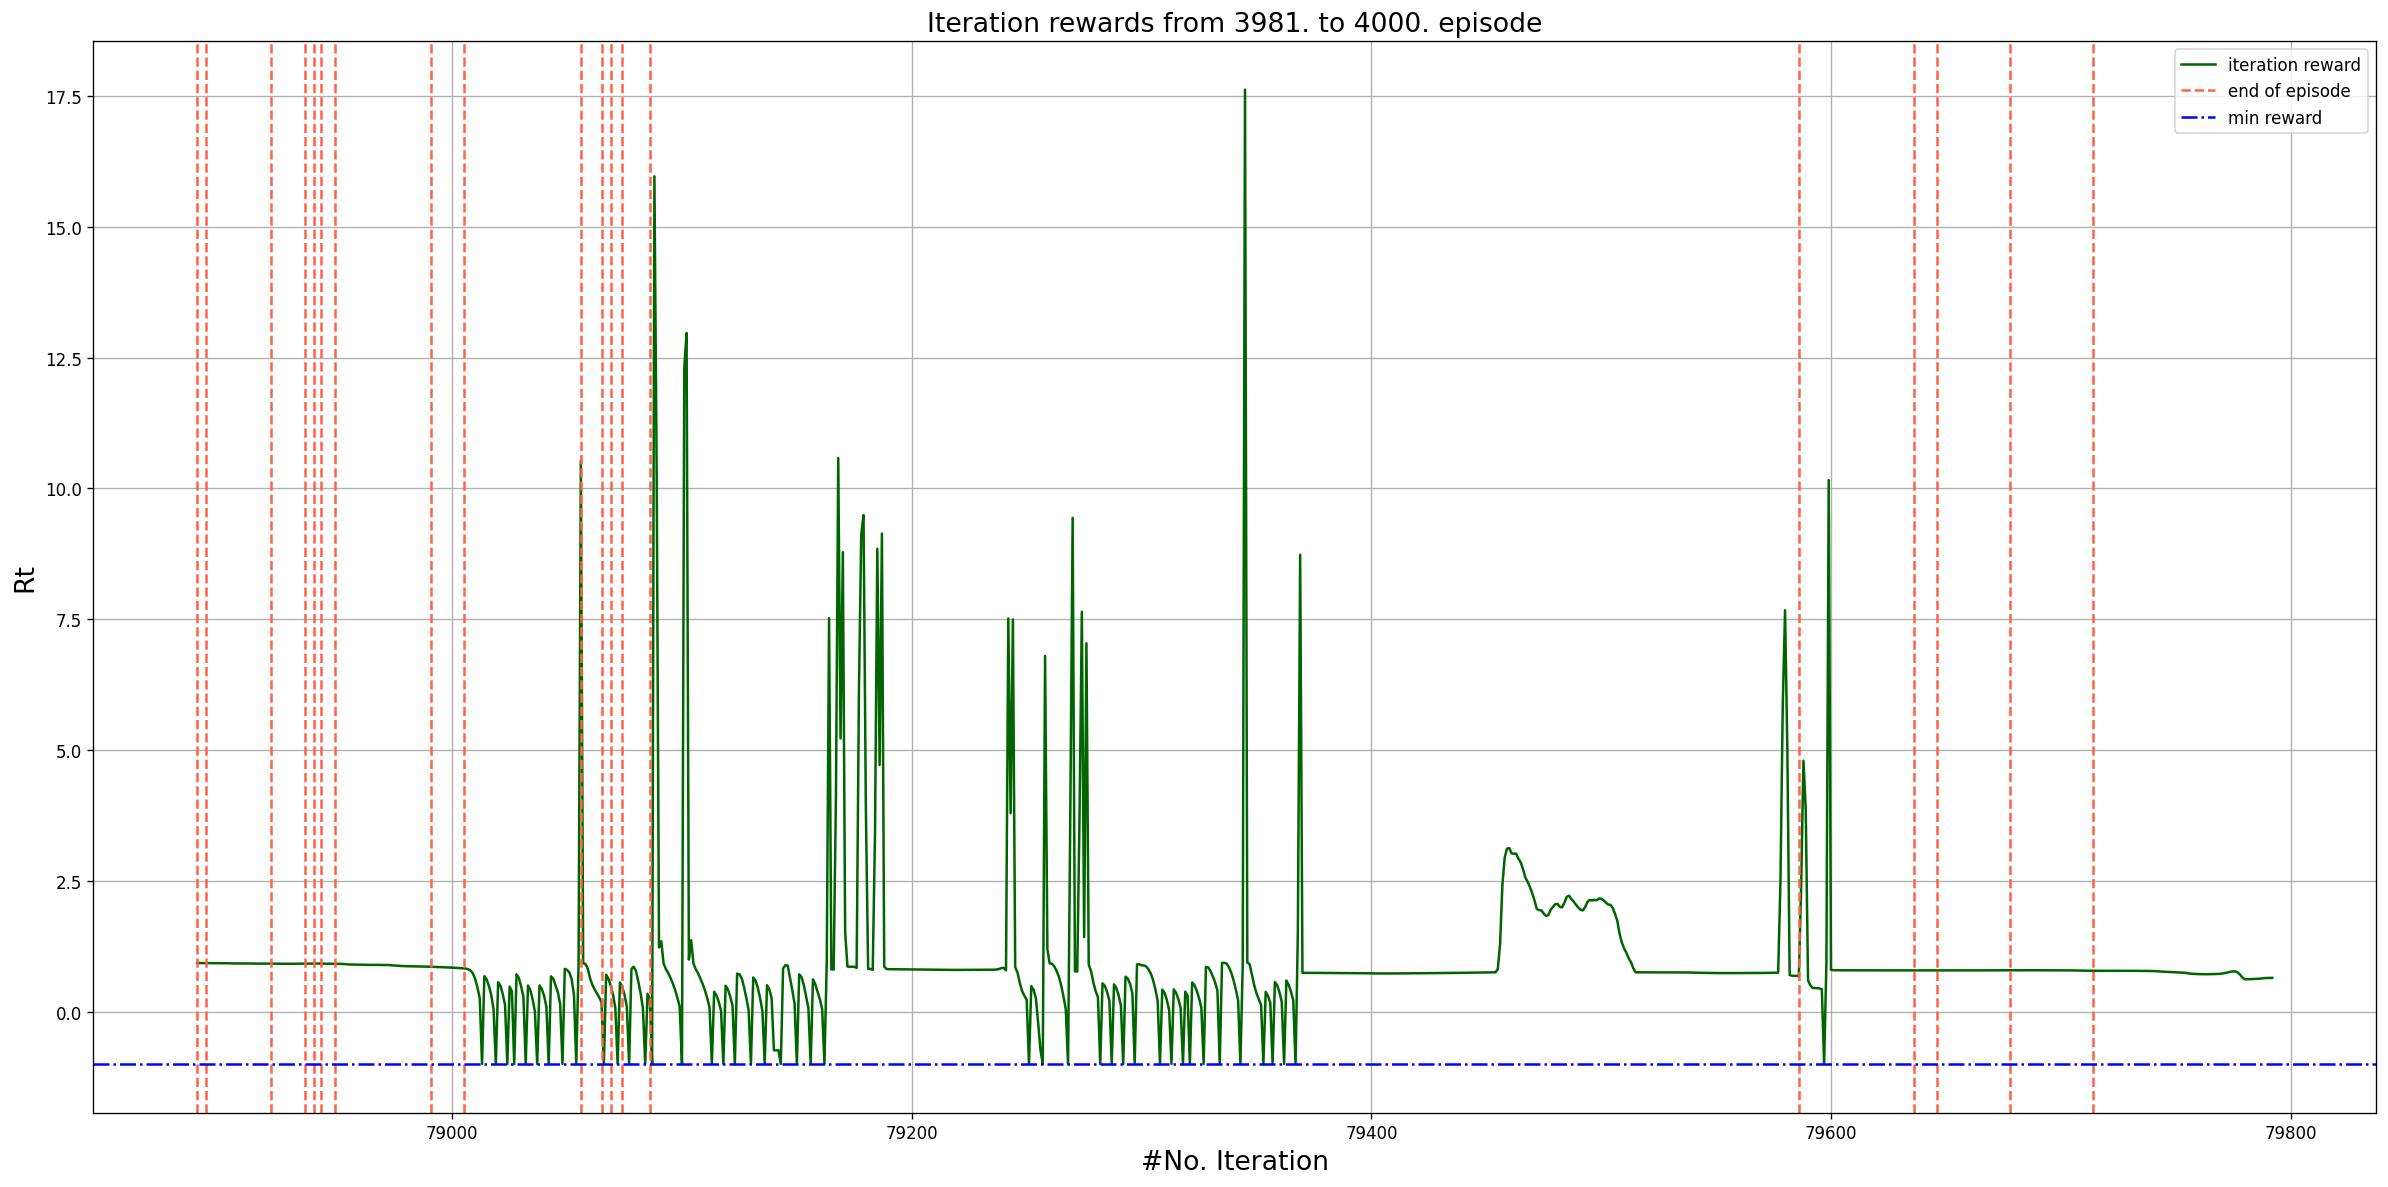

In [6]:
rewards, steps, episodic_rewards, average_episodic_rewards, TE, ST, AVG = get_data(['6th_training_1st'], total_episodes=1000, steps_per_episode=1000, average_episode_count=40)
plot_results('6th_training_1st', rewards, steps, episodic_rewards, average_episodic_rewards, TE, ST, AVG)

rewards, steps, episodic_rewards, average_episodic_rewards, TE, ST, AVG = get_data(['6th_training_2nd'], total_episodes=2000, steps_per_episode=1000, average_episode_count=40)
plot_results('6th_training_2nd', rewards, steps, episodic_rewards, average_episodic_rewards, TE, ST, AVG, -100, -1)

rewards, steps, episodic_rewards, average_episodic_rewards, TE, ST, AVG = get_data(['6th_training_3rd'], total_episodes=1000, steps_per_episode=500, average_episode_count=40)
plot_results('6th_training_3rd', rewards, steps, episodic_rewards, average_episodic_rewards, TE, ST, AVG, -20, -1)

rewards, steps, episodic_rewards, average_episodic_rewards, TE, ST, AVG = get_data(['6th_training_1st','6th_training_2nd', '6th_training_3rd'], total_episodes=4000, steps_per_episode=500, average_episode_count=40)
plot_results('6th_training', rewards, steps, episodic_rewards, average_episodic_rewards, TE, ST, AVG, -20, -1)
